In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

In [2]:
bm = pd.read_csv('results.csv')
print(len(bm))

31984


 We have 31984 data observations in our data set and 21 features. 

In [3]:
bm.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [4]:
bm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null object
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null object
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null object
5k           31984 non-null object
half         31984 non-null object
20k          31984 non-null object
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 5.1+ MB


We're missing a substantial portion of the ctz column, which seems to have country codes, but there's also a country column. We'll drop it. Let's make sure the numbers make sense for the continuous features. State also has some missing values, but not too many. We'll leave it for now. 

Also, the split times are stored as objects instead of ints or floats which will have to be dealt with. 

In [5]:
bm.drop('ctz', axis =1, inplace = True)

In [6]:
# Re-factor and use itertools.compress to create column list
cols = ['5k','10k', 'half', '20k','25k', '30k', '35k', '40k'] #why is there no 15k?
for col in cols:
    bm[col]= pd.to_numeric(bm[col], errors='coerce')


In [7]:
bm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 20 columns):
10k          31934 non-null float64
name         31984 non-null object
division     31984 non-null int64
25k          31768 non-null float64
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
35k          31950 non-null float64
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31944 non-null float64
5k           31932 non-null float64
half         31912 non-null float64
20k          31933 non-null float64
country      31984 non-null object
city         31983 non-null object
40k          31945 non-null float64
dtypes: float64(10), int64(4), object(6)
memory usage: 4.9+ MB


In [8]:
bm.describe()

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
count,31934.000000,31984.000000,31768.000000,31984.000000,31984.000000,31984.000000,31950.000000,31984.000000,31984.000000,31944.000000,31932.000000,31912.000000,31933.000000,31945.000000
mean,51.799275,1932.563032,133.612055,42.407079,242.997314,8051.044741,196.857605,15939.587825,9.275658,164.571219,25.755559,111.664566,105.711669,229.001490
std,8.965513,1715.228694,25.596958,11.316496,52.300431,4754.005626,41.979107,9232.978224,1.992486,33.953683,4.327830,21.061188,19.780525,49.159902
min,16.620000,1.000000,45.800000,18.000000,80.600000,1.000000,67.420000,1.000000,3.080000,56.450000,7.750000,38.030000,36.100000,76.100000
25%,45.400000,610.000000,115.470000,33.000000,205.527500,3972.000000,167.122500,7943.750000,7.850000,140.670000,22.650000,96.845000,91.750000,193.820000
50%,50.330000,1425.000000,128.875000,42.000000,232.370000,7970.000000,188.170000,15939.500000,8.870000,157.730000,25.080000,107.830000,102.150000,218.850000
75%,57.170000,2611.000000,147.735000,50.000000,273.235000,11968.000000,220.170000,23935.250000,10.430000,182.880000,28.470000,123.070000,116.520000,257.450000
max,112.380000,6979.000000,289.020000,81.000000,538.880000,17575.000000,449.330000,31931.000000,20.570000,376.380000,86.950000,236.670000,224.350000,508.350000


Wow. The oldest marathon finisher was 80, and the average age was 41. The Boston Marathon requires qualification, so it's not suprising to see the max pace is just under 11 min/mile. Let's explore these categorical columns. We also have some nulls that will probably come back to bite us when we scale.   We also see a 3 min/mile pace, but there are wheelchair racers in this group which average that kind of pace. 

In [9]:
bm.dropna(axis =0, how = 'any', inplace = True)

In [10]:
bm.nunique()

10k           2629
name         29044
division      6897
25k           6458
gender           2
age             64
official     10568
bib          29103
genderdiv    17124
35k           9124
overall      29082
pace           686
state           68
30k           7766
5k            1410
half          5408
20k           5150
country          2
city          4648
40k          10130
dtype: int64

Some of these make sense (Name, bib, overall). It's a little odd that the split times overlap as much as they do, but most runners probably cluster around min/mile paces so it's not entirely unexpected. Overall has roughly the same number as name and bib because it's the finishing order. Official appears to be the official time in (min.sec) form. 

Bib and name don't tell us anything here, so we'll drop them. 

In [11]:
bm.drop(['name', 'bib'], axis =1, inplace = True)

In [12]:
bm.city.value_counts().head(10)

Boston           1018
New York          497
Chicago           312
Cambridge         303
Somerville        239
Toronto           239
Brookline         219
Washington        209
Newton            195
San Francisco     192
Name: city, dtype: int64

In [13]:
bm.state.value_counts().head(10)

MA    7427
CA    2302
NY    1537
ON    1045
PA     997
TX     988
IL     911
OH     754
FL     745
VA     709
Name: state, dtype: int64

In [14]:
bm.country.value_counts().head(10)

USA    26939
CAN     2164
Name: country, dtype: int64

Nothing to see here. I could potentially come back later and group these by regions, but for now we'll just bid them adieu.

Also, we'll code M/F to 0/1 before we get into scaling and modeling. 

In [15]:
bm.drop(['country', 'state', 'city'], axis =1, inplace = True)

In [16]:
bm.gender = np.where(bm.gender == "M", 0, 1)

In [17]:
bm.head()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
9,30.48,20,77.68,0,31,137.83,20,112.27,20,5.27,94.78,15.15,65.23,61.78,129.83
14,17.12,13,48.88,0,29,87.40,13,72.83,13,3.35,60.82,8.02,40.20,38.02,82.38
15,33.93,10,85.03,1,30,143.90,10,119.68,46,5.50,102.40,16.92,71.68,67.92,136.47
24,18.30,14,50.33,0,47,89.40,14,74.95,14,3.42,62.33,8.67,41.80,39.63,84.48
27,18.78,15,50.33,0,30,89.52,15,75.02,15,3.42,62.72,8.98,41.82,39.65,84.75


If I have this right the workflow is:

Normalize data -> Scale data --> Split data in half --> Split data in half again --> MODEL

But first, lets make sure our rows divide evenly by 4. 

In [18]:
rows = bm.shape[0] - bm.shape[0] % 4
X = bm.iloc[:rows, :]

In [19]:
#Normalize and create dfs
X_norm = normalize(X)
ypred = pd.DataFrame()
scores = pd.DataFrame(columns = ['cluster', 'score']) #silhoute score

In [20]:
# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

In [21]:
# Halve the data once:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_norm,
    X_pca,
    test_size=0.5,
    random_state=42)

# halve the halves:
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)


## Kmeans Clustering

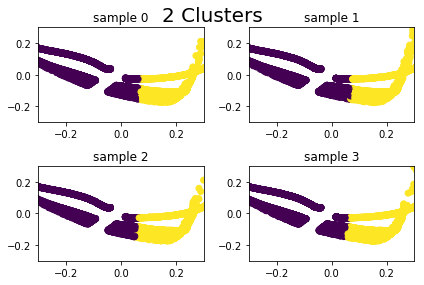

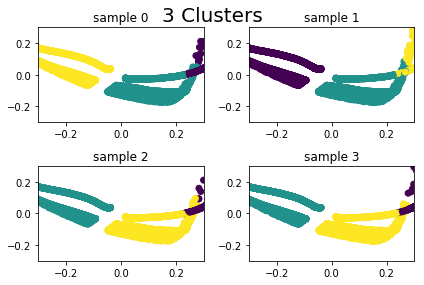

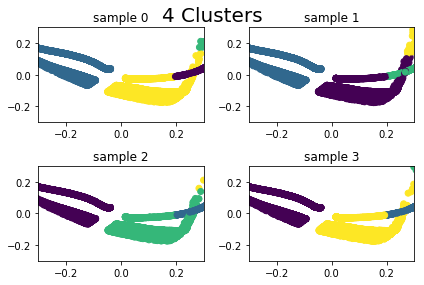

In [34]:
#Pass tuples into a list to be used by K-means
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
        #Add features to ypred.
        ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
        ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
        
        #Add features to cluster 2-5. (Same as above in a loop)
        for nclust in range(2, 5):
            kmeans = KMeans(n_clusters = nclust, random_state=42)
            pred = kmeans.fit_predict(data[0]) #data[0] is X or sample
            ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred
            labels = kmeans.labels_
            score = metrics.silhouette_score(data[0], labels, metric='euclidean')
            scores = scores.append({'cluster': 'clust' + str(nclust) + '_sample' + str(counter),
                                  'score': score}, ignore_index=True)
            
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.3, .3])
        axarr[rows, cols].set_ylim([-.3, .3])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')
            

In [210]:
scores.sort_values(by='score', ascending=False)

,cluster,score
11,clust4_sample3,0.494623
5,clust4_sample1,0.494448
8,clust4_sample2,0.493280
2,clust4_sample0,0.490502
7,clust3_sample2,0.480800
4,clust3_sample1,0.478718
10,clust3_sample3,0.478513
1,clust3_sample0,0.474704
0,clust2_sample0,0.464484
9,clust2_sample3,0.461082


4 samples has both the highest scores and the most consistent scores. We used sihouette instead of ARI becuase we don't have a "ground truth".

## Spectral Clustering

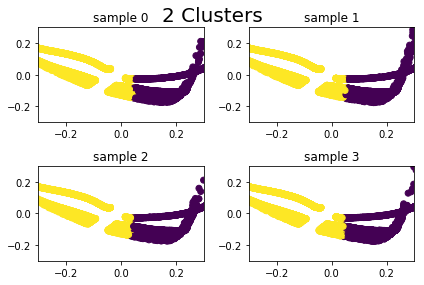

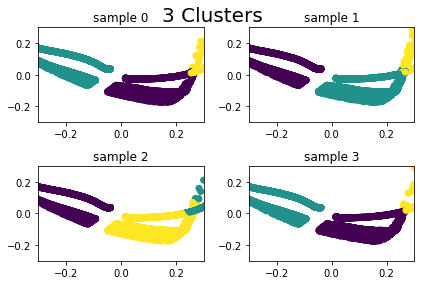

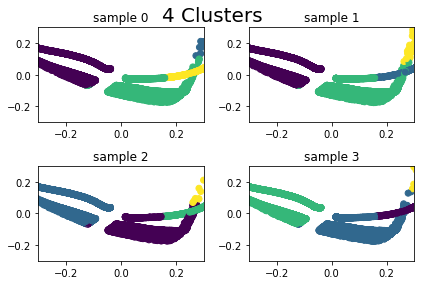

In [222]:
#re-initialize dfs
sc_scores = pd.DataFrame(columns = ['cluster', 'score']) #silhoute score
sc_ypred = pd.DataFrame()
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
        #Add features to sc_ypred.
        sc_ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
        sc_ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
        
        #Add features to cluster 2-5. (Same as above in a loop)
        for nclust in range(2, 5):
            sc = SpectralClustering(n_clusters = nclust, random_state=42)
            pred = sc.fit_predict(data[0]) #data[0] is X or sample
            sc_ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred
            labels = sc.labels_
            sc_score = metrics.silhouette_score(data[0], labels, metric='euclidean')
            sc_scores = sc_scores.append({'cluster': 'clust' + str(nclust) + '_sample' + str(counter),
                                  'score': sc_score}, ignore_index=True)
            
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = sc_ypred['pca_f1_sample{}'.format(i)]
        y_sub = sc_ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = sc_ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.3, .3])
        axarr[rows, cols].set_ylim([-.3, .3])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')
            

In [223]:
sc_scores.sort_values(by='score', ascending=False)

,cluster,score
11,clust4_sample3,0.491312
5,clust4_sample1,0.490632
8,clust4_sample2,0.489900
2,clust4_sample0,0.485686
7,clust3_sample2,0.480765
4,clust3_sample1,0.478232
10,clust3_sample3,0.477068
1,clust3_sample0,0.472798
9,clust2_sample3,0.448360
0,clust2_sample0,0.445663


Again 4 clusters has the best scores and the tighest range of scores. It performs slightly worse than K-means. 

## Mean-Shift Clustering

In [247]:
#re-initialize dfs
ms_scores = pd.DataFrame(columns = ['cluster', 'ms_score']) #silhoute score
ms_ypred = pd.DataFrame()

for counter, data in enumerate([X1, X2, X3, X4]):
   
        # Estimating number of clusters for data
        bandwidth = estimate_bandwidth(data, n_samples=500)
        
        #Add features to cluster 2-5. (Same as above in a loop)
        for nclust in range(2, 5):
            ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
            pred = ms.fit_predict(data) #data[0] is X or sample
            ms_ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred
            labels = ms.labels_
            ms_score = metrics.silhouette_score(data, labels, metric='euclidean')
            ms_scores = ms_scores.append({'cluster': 'clust' + str(nclust) + '_sample' + str(counter),
                                  'ms_score': ms_score}, ignore_index=True)
            
            

In [248]:
ms_scores.sort_values(by='ms_score', ascending=False)

,cluster,ms_score
3,clust2_sample1,0.559720
4,clust3_sample1,0.559720
5,clust4_sample1,0.559720
0,clust2_sample0,0.496654
1,clust3_sample0,0.496654
2,clust4_sample0,0.496654
9,clust2_sample3,0.494659
10,clust3_sample3,0.494659
11,clust4_sample3,0.494659
6,clust2_sample2,0.494610


I wish I could have gotten the graphing to work, because the scores are very similar. Mean-Shift didn't perform very well across the different samples, but the lower performing scores were higher than what we saw from K-means and Spectral Clustering. Becuase all of the ranges vary, 2 clusters performed best here. 

## Affinity Propogation

In [22]:
#re-initialize dfs
ap_scores = pd.DataFrame(columns = ['cluster', 'ap_score']) #silhoute score
ap_ypred = pd.DataFrame()

for counter, data in enumerate([X1, X2, X3, X4]):
   
        # Estimating number of clusters for data
        bandwidth = estimate_bandwidth(data, n_samples=500)
        
        #Add features to cluster 2-5. (Same as above in a loop)
        for nclust in range(2, 5):
            af = AffinityPropagation().fit(data)
            cluster_centers_indices = af.cluster_centers_indices_
            n_clusters_ = len(cluster_centers_indices)
            
            #ms_ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred
            #Create scores
            labels = af.labels_
            af_score = metrics.silhouette_score(data, labels, metric='euclidean')
            af_scores = af_scores.append({'cluster': 'clust' + str(nclust) + '_sample' + str(counter),
                                  'af_score': af_score}, ignore_index=True)

KeyboardInterrupt: 

Affinity propogation made my browser crash twice, and tried to do it a third time. Based on the previous lessons, it wouldn't have performed very well anyway. It will be excluded until my laptop gets fixed and I'm not using a dying 2011 laptop. 

## Summary

K-Means and Spectral Clustering performed reasonably well and the silhouette scores were consistent across the samples, both suggest 4 clusters were the correct amount. Mean-Shift clustering had higher silhoutte scores, but it didn't hold up well within samples - it suggested 2 clusters. 

4 groups of runners in the boston marathon intuitively makes sense. We can see from the summary statistics that there is a clear group out front(The rollers and the elite runners), then quicker and slower median groups, as well as large lagging group. 

In [23]:
bm.describe()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
count,29103.000000,29103.000000,29103.000000,29103.000000,29103.000000,29103.000000,29103.000000,29103.000000,29103.000000,29103.000000,29103.000000,29103.000000,29103.000000,29103.000000,29103.000000
mean,51.827082,1966.941037,134.107068,0.464729,42.054256,242.813434,8008.425935,196.771704,15980.928942,9.269305,164.525433,25.779254,111.639899,105.728655,229.037616
std,8.704309,1732.202728,25.627832,0.498763,11.348288,50.921669,4733.455790,40.869530,9169.893647,1.942165,32.965134,4.207013,20.333671,19.186131,48.164805
min,17.120000,1.000000,48.550000,0.000000,18.000000,84.820000,1.000000,70.830000,1.000000,3.250000,59.770000,8.020000,40.200000,38.020000,80.180000
25%,45.580000,623.500000,115.920000,0.000000,33.000000,205.980000,3954.500000,167.550000,8074.500000,7.870000,141.075000,22.730000,97.180000,92.070000,194.280000
50%,50.430000,1445.000000,129.230000,0.000000,42.000000,232.570000,7923.000000,188.400000,15997.000000,8.880000,157.980000,25.150000,108.020000,102.350000,219.120000
75%,57.200000,2703.500000,148.430000,1.000000,50.000000,273.310000,11908.500000,220.270000,23946.000000,10.430000,183.125000,28.500000,123.200000,116.650000,257.780000
max,112.380000,6979.000000,289.020000,1.000000,81.000000,538.880000,17575.000000,449.330000,31931.000000,20.570000,376.380000,86.950000,236.670000,224.350000,508.350000


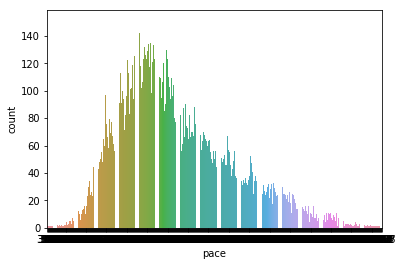

In [30]:
sns.countplot(x = 'pace', data = bm)
plt.show()

In [35]:
kmeans.labels_

array([3, 1, 0, ..., 3, 3, 3], dtype=int32)